In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [15]:
data_transforms = {
    'training_set': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test_set': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [16]:
data_dir = 'C:\\Users\\Vivek.Sasikumar\\Downloads\\Convolutional_Neural_Networks\\dataset\\'
#Create a dictionary that contains the information of the images in both the training and validation set
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['training_set', 'test_set']}
#Create a dictionary that contians the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,
                                              shuffle=True) for x in ['training_set', 'test_set']}

#Create a dictionary that contains the size of each dataset (training and validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['training_set', 'test_set']}
#Get the class names
class_names = image_datasets['training_set'].classes
#Print out the results 
print("Class Names: {}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['training_set'])))
print("There are {} batches in the test set".format(len(dataloaders['test_set'])))
print("There are {} training images".format(dataset_sizes['training_set']))
print("There are {} testing images".format(dataset_sizes['test_set']))

Class Names: ['cats', 'dogs']
There are 2000 batches in the training set
There are 500 batches in the test set
There are 8000 training images
There are 2000 testing images


In [4]:
#Load the ResNet
model_conv = torchvision.models.resnet18(pretrained=True)

In [5]:
#Freeze all layers in the network  
for param in model_conv.parameters():  
    param.requires_grad = False

In [6]:
#Get the number of inputs of the last layer (or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
#Reconstruct the last layer (output layer) to have only two classes 
model_conv.fc = nn.Linear(num_ftrs, 2)

In [7]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [13]:
#Understand what's happening
iteration = 0
correct = 0
for inputs,labels in dataloaders['training_set']:
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    print("Labels are: {}".format(labels))
    output = model_conv(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted:", predicted)
    print("Predicted Shape",predicted.shape)
    correct += (predicted == labels).sum()   
    print("Correct Predictions:",correct)
    
    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([0, 1, 0, 0])
Output Tensor: tensor([[-0.1423,  0.0548],
        [-0.4756,  0.1708],
        [-0.1750, -0.1173],
        [ 0.0364, -0.0361]], grad_fn=<ThAddmmBackward>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([1, 1, 1, 0])
Predicted Shape torch.Size([4])
Correct Predictions: tensor(2)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#Try experimenting with: optim.Adam(model_conv.fc.parameters(), lr=0.001)
#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
#This is to demonstrate what happens in the background of scheduler.step()
#No need to run this cell unless you want to create your own scheduler 
def lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [16]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []


import time
num_epochs = 20
for epoch in range (num_epochs):
    start = time.time()
    exp_lr_scheduler.step()
    #Reset the correct to 0 after passing through all the dataset
    correct = 0
    for images,labels in dataloaders['training_set']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        optimizer.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == labels).sum()
        
    train_acc = 100 * correct / dataset_sizes['training_set'] 
    stop = time.time()
    print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {}%, Time: {:.2f}s'
            .format(epoch+1, num_epochs, loss.item(), train_acc, stop-start))

Epoch [1/20], Loss: 0.0662, Train Accuracy: 81%, Time: 1226.41s
Epoch [2/20], Loss: 0.0049, Train Accuracy: 80%, Time: 1119.31s
Epoch [3/20], Loss: 1.6648, Train Accuracy: 82%, Time: 1064.37s
Epoch [4/20], Loss: 1.3075, Train Accuracy: 82%, Time: 1143.28s
Epoch [5/20], Loss: 0.1149, Train Accuracy: 82%, Time: 4375.31s
Epoch [6/20], Loss: 0.2378, Train Accuracy: 81%, Time: 1234.05s
Epoch [7/20], Loss: 0.8357, Train Accuracy: 80%, Time: 1229.77s
Epoch [8/20], Loss: 0.1532, Train Accuracy: 83%, Time: 2806.37s
Epoch [9/20], Loss: 0.0700, Train Accuracy: 84%, Time: 1269.05s
Epoch [10/20], Loss: 0.4523, Train Accuracy: 84%, Time: 1248.64s
Epoch [11/20], Loss: 1.2474, Train Accuracy: 84%, Time: 1255.72s
Epoch [12/20], Loss: 1.3583, Train Accuracy: 85%, Time: 1403.35s
Epoch [13/20], Loss: 0.2190, Train Accuracy: 85%, Time: 1372.12s
Epoch [14/20], Loss: 0.0701, Train Accuracy: 84%, Time: 1258.08s
Epoch [15/20], Loss: 0.3465, Train Accuracy: 85%, Time: 1256.79s
Epoch [16/20], Loss: 0.2194, Train

In [21]:
import time
# Test the model
model_conv.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in dataloaders['test_set']:
        start = time.time()
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    stop = time.time()

    print('Test Accuracy: {:.3f} %, Time: {:.2f}s'.format(100 * correct / total,stop-start))

Test Accuracy: 97.000 %, Time: 0.59s


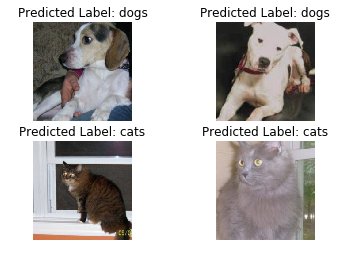

In [22]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['test_set']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)

In [23]:
#Run this if you want to save the model
torch.save(model_conv.state_dict(),'Cats-Dogs1.pth')

In [24]:
model_conv.load_state_dict(torch.load('Cats-Dogs1.pth'))

In [25]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
#Predict your own image
def predict(img_name,model):
    image = cv2.imread(img_name)   #Read the image
    #ret, thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)   #Threshold the image
    img = Image.fromarray(image)      #Convert the image to an array
    img = transforms_photo(img)     #Apply the transformations 
    img = img.view(1,3,224,224)       #Add batch size 
    img = Variable(img)      
   #Wrap the tensor to a variable
    
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    if predicted.item()==0:
        p = 'Cat'
    else:
        p = 'Dog'
    cv2.imshow('Original',image)
    return  p

In [26]:
transforms_photo = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

In [27]:
pred = predict('C://Users//Vivek.Sasikumar//Downloads//Convolutional_Neural_Networks//dataset//single_prediction//cat_or_dog_2.jpg', model_conv)
print("The Predicted Label is {}".format(pred))

tensor([[ 1.9303, -1.7688]], grad_fn=<ThAddmmBackward>)
tensor([[ 1.9303, -1.7688]])
The Predicted Label is Cat
